# IBM Analog Hardware Acceleration Kit (AIHWKIT): Post Training Input Range Calibration

### Authors: [Julian Büchel](https://www.linkedin.com/in/julian-büchel-0673991a3/), [Manuel Le Gallo-Bourdeau](https://research.ibm.com/people/manuel-le-gallo-bourdeau), and [Kaoutar El Maghraoui](https://www.linkedin.com/in/kaoutar-el-maghraoui/)

In this notebook, we show how you can use the aihwkit library to perform post-training input range calibration for a pre-trained Analog model to improve its inference accuracy.

<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/tutorial/post_training_input_range_calibration.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open-source Python toolkit for exploring and using the capabilities of in-memory computing devices (PCM, RRAM and others) in the context of artificial intelligence. The PyTorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.
The GitHub repository can be found at: https://github.com/IBM/aihwkit
To learn more about Analog AI and the harware befind it, refer to this webpage: https://aihw-composer.draco.res.ibm.com/about

##Installing AIHWKIT

The first thing to do is install AIHWKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, un-comment the line below
#!pip install aihwkit

# To install the GPU-enabled wheel, use the commands below.
!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


--2023-07-13 15:37:01--  https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Resolving aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud)... 169.63.118.98
Connecting to aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud)|169.63.118.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 421133593 (402M) [application/octet-stream]
Saving to: ‘aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl’

aihwkit-0.8.0+cuda1 100%[===================>] 401.62M  13.1MB/s    in 33s     

2023-07-13 15:37:35 (12.2 MB/s) - ‘aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl’ saved [421133593/421133593]

Processing ./aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_

In [ ]:
# various utility functions

import torch
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import numpy as np
import os
from typing import List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _weights_init(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    torch.nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, n_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = torch.nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, n_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet32(n_classes=10):
    return ResNet(BasicBlock, [5, 5, 5], n_classes=n_classes)

class TorchCutout(object):
    def __init__(self, length, fill=(0.0, 0.0, 0.0)):
        self.length = length
        self.fill = torch.tensor(fill).reshape(shape=(3, 1, 1))

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)
        img[:, y1:y2, x1:x2] = self.fill
        return img


# Load dataset
def load_cifar10(batch_size, path):
    transform_train = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
            TorchCutout(length=8),
        ]
    )

    transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=path, train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root=path, train=False, download=True, transform=transform_test
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=1
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=1
    )

    return trainloader, testloader


def load_cifar10_ffcv(batch_size, path):
    # - FFCV specific imports
    from ffcv.fields import IntField, RGBImageField
    from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
    from ffcv.loader import Loader, OrderOption
    from ffcv.pipeline.operation import Operation
    from ffcv.transforms import (
        RandomHorizontalFlip,
        Cutout,
        RandomTranslate,
        Convert,
        ToDevice,
        ToTensor,
        ToTorchImage,
    )
    from ffcv.transforms.common import Squeeze
    from ffcv.writer import DatasetWriter

    datasets = {
        "train": torchvision.datasets.CIFAR10(path, train=True, download=True),
        "test": torchvision.datasets.CIFAR10(path, train=False, download=True),
    }

    for name, ds in datasets.items():
        writer = DatasetWriter(
            os.path.join(path, f"cifar_{name}.beton"),
            {"image": RGBImageField(), "label": IntField()},
        )
        writer.from_indexed_dataset(ds)

    # Note that statistics are wrt to uin8 range, [0,255].
    CIFAR_MEAN = [125.307, 122.961, 113.8575]
    CIFAR_STD = [51.5865, 50.847, 51.255]

    loaders = {}
    for name in ["train", "test"]:
        label_pipeline: List[Operation] = [
            IntDecoder(),
            ToTensor(),
            ToDevice(device),
            Squeeze(),
        ]
        image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

        # Add image transforms and normalization
        if name == "train":
            image_pipeline.extend(
                [
                    RandomTranslate(padding=4),
                    RandomHorizontalFlip(),
                    Cutout(
                        8, tuple(map(int, CIFAR_MEAN))
                    ),  # - Note Cutout is done before normalization.
                ]
            )
        image_pipeline.extend(
            [
                ToTensor(),
                ToDevice(device, non_blocking=True),
                ToTorchImage(),
                Convert(torch.float32),
                torchvision.transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
            ]
        )

        # - Create loaders
        loaders[name] = Loader(
            os.path.join(path, f"cifar_{name}.beton"),
            batch_size=batch_size,
            num_workers=4,
            order=OrderOption.RANDOM,
            drop_last=(name == "train"),
            pipelines={"image": image_pipeline, "label": label_pipeline},
        )

    return loaders["train"], loaders["test"]


Import the necessary modules to perform the Post-training calibration.

In [ ]:
# - Generic imports
import torch
import numpy as np
import os

# - Tutorial specific imports
#from utils.misc import load_cifar10, device, resnet32
#from utils.plotting import plt

# - AIHWKIT related imports
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.simulator.presets.utils import IOParameters
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import (
    WeightModifierType,
    BoundManagementType,
    WeightClipType,
    NoiseManagementType,
    WeightRemapType,
)
from aihwkit.inference.calibration import calibrate_input_ranges, InputRangeCalibrationType

#from aihwkit.calibration import calibrate_input_ranges
#from aihwkit.simulator.configs import InputRangeCalibrationType

Define the RPU configuration that abstracts all the hardware related parameters and noise characteristics of the simulated Analog hardware.

In [ ]:
def gen_rpu_config():
    rpu_config = InferenceRPUConfig()
    rpu_config.modifier.std_dev = 0.06
    rpu_config.modifier.type = WeightModifierType.ADD_NORMAL

    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.weight_scaling_omega = 1.0
    rpu_config.mapping.weight_scaling_columnwise = False
    rpu_config.mapping.out_scaling_columnwise = False
    rpu_config.remap.type = WeightRemapType.LAYERWISE_SYMMETRIC

    rpu_config.clip.type = WeightClipType.LAYER_GAUSSIAN
    rpu_config.clip.sigma = 2.0

    rpu_config.forward = IOParameters()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.out_noise = 0.0
    rpu_config.forward.inp_bound = 1.0
    rpu_config.forward.inp_res = 1 / (2**8 - 2)
    rpu_config.forward.out_bound = 12
    rpu_config.forward.out_res = 1 / (2**8 - 2)
    rpu_config.forward.bound_management = BoundManagementType.NONE
    rpu_config.forward.noise_management = NoiseManagementType.NONE

    rpu_config.pre_post.input_range.enable = True
    rpu_config.pre_post.input_range.decay = 0.01
    rpu_config.pre_post.input_range.init_from_data = 50
    rpu_config.pre_post.input_range.init_std_alpha = 3.0
    rpu_config.pre_post.input_range.input_min_percentage = 0.995
    rpu_config.pre_post.input_range.manage_output_clipping = False

    rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config


def test_step(model, criterion, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f"Test loss {test_loss/total:.4f} test acc. {100.*correct/total:.2f}%")
    return 100.0 * correct / total

Load the datase, define the ResNet32 model, optimizer and scheduler.

In [ ]:
# - Set seeds
torch.manual_seed(0)
np.random.seed(0)
# - Get the dataloader
batch_size = 128
trainloader, testloader = load_cifar10(
    batch_size=batch_size, path=os.path.expanduser("~/Data")
)

# - Define model, criterion, optimizer and scheduler.
model = resnet32()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# - Set seeds
torch.manual_seed(0)
np.random.seed(0)
# - Get the dataloader
batch_size = 128
trainloader, testloader = load_cifar10(
    batch_size=batch_size, path=os.path.expanduser("~/Data/")
)

# - Change to True if one of the models should be re-trained
retrain_baseline = False
retrain_finetuned_model = False

# - Some hyperparameters
lr = 0.05
epochs = 200
epochs_finetuning = 200

Files already downloaded and verified
Files already downloaded and verified


Convert the ResNet model to its Analog version. Initialize the analog model withpre-trained and fine-tuned model's weights.

In [ ]:
analog_model = convert_to_analog(model, gen_rpu_config())
!wget -P Models/ https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/finetuned_model.th
analog_model.load_state_dict(
    torch.load("Models/finetuned_model.th", map_location=device)
)
for tile_name, tile in analog_model.named_analog_tiles():
    print(f"{tile_name} input range {tile.input_range.data.item():.4f}")
print(f"Test acc. (learned input ranges) {test_step(analog_model, criterion, testloader)}%")

--2023-07-13 15:51:50--  https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/finetuned_model.th
Resolving aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)... 169.63.118.98
Connecting to aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)|169.63.118.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8117433 (7.7M) [application/octet-stream]
Saving to: ‘Models/finetuned_model.th’

finetuned_model.th  100%[===================>]   7.74M   353KB/s    in 26s     

2023-07-13 15:52:18 (299 KB/s) - ‘Models/finetuned_model.th’ saved [8117433/8117433]

module.conv1.analog_module input range 2.7523
module.layer1.0.conv1.analog_module input range 1.2347
module.layer1.0.conv2.analog_module input range 1.0859
module.layer1.1.conv1.analog_module input range 1.3147
module.layer1.1.conv2.analog_m

The calibration routine expects an iterator that feeds single elements that the network expects as inputs. These elements can be anything (e.g., tensors or dictionaries) as long as the model can process them.
The next class demonstrates a simple `Sampler` that takes as input another iterator (torch dataloader) and yields only the images. The iterator can be halted by raising the `StopIteration` exception, which is used in this case to limit the number of presented batches.

In [ ]:
class Sampler:
    """Example of a sampler used for calibration."""

    def __init__(self, loader):
        self.loader = iter(loader)
        self.idx = 0

    def __iter__(self):
        return self

    def __next__(self):
        x, _ = next(self.loader)
        self.idx += 1
        if self.idx > 10:
            raise StopIteration
        return x.to(device)

In [ ]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams["font.size"] = 16
rcParams["axes.linewidth"] = 1.1
rcParams["axes.labelpad"] = 3.0
plot_color_cycle = plt.cycler(
    "color",
    [
        "#9b59b6",
        "#3498db",
        "#95a5a6",
        "#e74c3c",
        "#34495e",
        "#2ecc71",
        "#1E2460",
        "#B5B8B1",
        "#734222",
        "#A52019",
    ],
)
rcParams["axes.prop_cycle"] = plot_color_cycle
rcParams["axes.xmargin"] = 0
rcParams["axes.ymargin"] = 0
rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.subplot.left": 0.07,
        "figure.subplot.right": 0.946,
        "figure.subplot.bottom": 0.1,
        "figure.subplot.top": 0.965,
        "axes.autolimit_mode": "round_numbers",
        "axes.grid": True,
        "xtick.major.size": 7,
        "xtick.minor.size": 3.5,
        "xtick.major.width": 1.1,
        "xtick.minor.width": 1.1,
        "xtick.major.pad": 5,
        "xtick.minor.visible": True,
        "ytick.major.size": 7,
        "ytick.minor.size": 3.5,
        "ytick.major.width": 1.1,
        "ytick.minor.width": 1.1,
        "ytick.major.pad": 5,
        "ytick.minor.visible": True,
        "lines.markersize": 10,
        "lines.markerfacecolor": "none",
        "lines.markeredgewidth": 0.8,
    }
)


We will now sweep the quantiles and look at the downstream performance for each quantile.

Test loss 0.0018 test acc. 94.31%
Test loss 0.0017 test acc. 94.37%
Test loss 0.0018 test acc. 93.67%
Test loss 0.0120 test acc. 53.19%


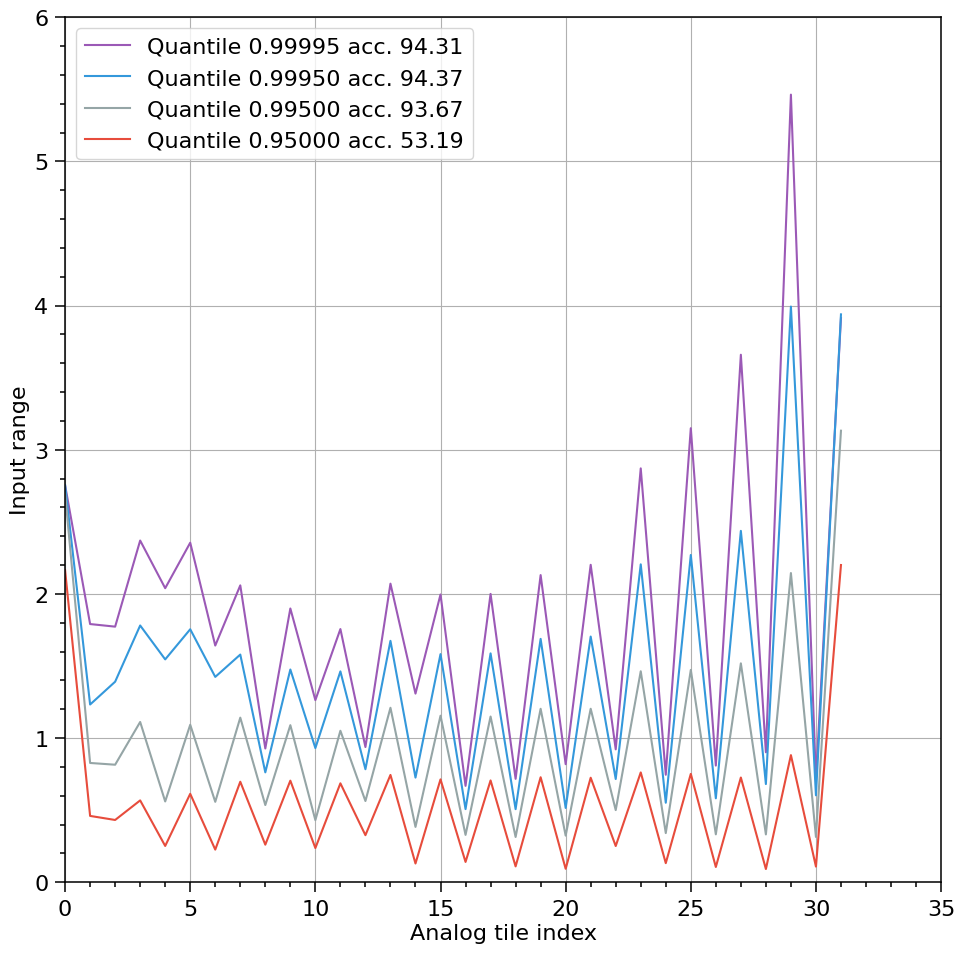

In [ ]:
plt.figure(figsize=(10,10))
quantiles = [0.99995, 0.9995, 0.995, 0.95]
for quantile in quantiles:
    sampler = Sampler(trainloader)
    calibrate_input_ranges(
        model=analog_model,
        calibration_type=InputRangeCalibrationType.CACHE_QUANTILE,
        dataloader=sampler,
        quantile=quantile,
        max_samples=1000
    )
    test_acc = test_step(analog_model, criterion, testloader)
    input_ranges = [tile.input_range.data.item() for tile in analog_model.analog_tiles()]
    plt.plot(input_ranges, label=f"Quantile {quantile:.5f} acc. {test_acc:.2f}")

plt.xlabel("Analog tile index")
plt.ylabel("Input range")
plt.legend()
plt.show()

As you can see from the above graph, the best quantile is 0.9995, as it yields the best accuracy. For more modes of calibrating the input ranges, check out `aihwkit.simulator.parameters.enums.InputRangeCalibrationType`